In [1]:
import numpy as np
from sympy import symbols
from contextlib import redirect_stdout
import subprocess
import matplotlib.pyplot as plt
from mpmath import mp
import datetime
import copy

In [2]:
#Set up mpmath here
mp.prec = 200 # Sets the precision of calculations in bits
print(mp)

Mpmath settings:
  mp.prec = 200               [default: 53]
  mp.dps = 59                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
class SDPAWrapper:
    def __init__(self):
        self.status = None
        self.oval = None
        self.xval = None
    
    def run(self, file='aho'):
        args = ['sdpa_gmp',f'{file}.dat',f'{file}.result']
        subprocess.run(args, stdout=subprocess.DEVNULL)
        with open(f'{file}.result','r') as f:
            lines = f.readlines()
            for lpos, line in enumerate(lines):
                if line.startswith('phase.value'):
                    self.status = line.split(' ')[2]
                if line.startswith('objValPrimal'):
                    self.oval = np.double(line.split(' ')[2])
                if line.startswith('xVec'):
                    self.xval = np.array(lines[lpos + 1][1:-2].split(','), dtype=np.double)

# You do not need to create any more instances of this class
# SDPARunObject runs the data file and stores the status, objective value, and the values of the optimization variables
SDPARunObject = SDPAWrapper()

In [4]:
class Problem:
    def __init__(self, K, problem_name):
        self._K = K
        self._name = problem_name
        self._basis = None
        self._freevars = None
        self._freevars_index_map = None
        self._index_freevars_map = None
        self._E = symbols('E')

    def _initialize_basis(self):
        raise NotImplementedError

    def _implement_recursion(self):
        raise NotImplementedError

    def _get_free_variables(self):
        raise NotImplementedError

    def initialize_problem(self):
        self._initialize_basis()
        self._implement_recursion()
        self._get_free_variables()
    
    def _generate_sdpa_matrices(self):
        raise NotImplementedError
    
    def _write_input(self, energy, file):
        raise NotImplementedError

    def solve(self, energy, write_to_log=True):
        with open('not_opt.log','a') as logfile:
            with open('aho.dat','w') as datafile:
                self._write_input(energy, datafile)
            SDPARunObject.run()
            if write_to_log == True and SDPARunObject.status != 'pdOPT':
                logfile.write(f'[{datetime.datetime.now()}]: name={self._name} | K={self._K} | status={SDPARunObject.status} | energy={energy}\n')
            return SDPARunObject.oval


In [5]:
class HankelProblem(Problem):
    def __init__(self, K, problem_name):
        super().__init__(K, problem_name)
        self._internal_matrix = None
    
    def _get_free_variables(self):
        self._freevars = set()
        for v1 in self._basis:
            for v2 in v1:
                self._freevars |= v2.free_symbols
        # The energy is not a free variable
        self._freevars.discard(self._E)

        # Map each free variable to a number
        self._freevars_index_map = dict()
        self._index_freevars_map = dict()
        for i, fvar in enumerate(self._freevars):
            self._freevars_index_map[fvar] = i
            self._index_freevars_map[i] = fvar
    
    def _generate_internal_matrix_structure(self):
        raise NotImplementedError

    def initialize_problem(self):
        super().initialize_problem()
        self._generate_internal_matrix_structure()
    
    def _internal_matrix_energy_substitution(self, energy):
        M = copy.deepcopy(self._internal_matrix)
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                M[i, j] = M[i, j].subs([(self._E, energy)])
        return M
    
    def _generate_sdpa_matrices(self, energy):
        M = self._internal_matrix_energy_substitution(energy)
        # [F0] + [F1,...,Fc] + [t]
        Fs = [np.zeros_like(M)] + [np.zeros_like(M) for _ in range(len(self._freevars))] + [np.eye(M.shape[0])]
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                term = M[i, j]
                for t, coeff in term.as_coefficients_dict().items():
                    if t == 1:
                        Fs[0][i, j] -= np.double(coeff)
                        continue
                    Fs[1 + self._freevars_index_map[t]][i, j] += np.double(coeff)
        return Fs

    def _write_input(self, energy, file):
        flatten = lambda xss: [x for xs in xss for x in xs]
        with redirect_stdout(file):
            print(f'*Energy: {energy}')
            print('*Potential name: ' + self._name)
            print(1 + len(self._freevars)) # mDIM
            print(1) # nBLOCK
            print(self._internal_matrix.shape[0]) # bLOCKsTRUCT
            c = np.zeros(1 + len(self._freevars))
            c[-1] = 1
            print(*c)
            Fs = self._generate_sdpa_matrices(energy)
            for F in Fs:
                print(*flatten(F.tolist()))

In [6]:
class SUSYProblem(HankelProblem):  
    def _initialize_basis(self):
        self._basis = [None] * 4
        self._basis[0] = [symbols(f'x_{i}') for i in range(2*self._K)]
        self._basis[1] = [symbols(f'x_{i}p^2') for i in range(2*self._K)]
        self._basis[2] = [symbols(f'x_{i}PP^^') for i in range(2*self._K)]
        self._basis[3] = [symbols(f'x_{i}p^2PP^^') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x_0': 1})

        # Base condition
        self._basis[0][4] = 4 * self._E / 3

        # Recursion for <x>
        for t in range(len(self._basis[0]) - 6):
            self._basis[0][t+6] = (1/2)*((t+3)*(t+2)*(t+1)*self._basis[0][t] + 4*(t+3)*self._basis[1][t+2])
            self._basis[0][t+6].simplify()
        # Recursion for <xPP^^>
        for t in range(len(self._basis[0]) - 6):
            self._basis[2][t+6] = (1/2)*((t+3)*(t+2)*(t+1)*self._basis[2][t] + 4*(t+3)*self._basis[3][t+2] + self._basis[2][t+3])
            self._basis[2][t+6].simplify()
    
    def _generate_internal_matrix_structure(self):
        M0 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        M2 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<xPP^^>

        for i in range(self._K):
            for j in range(self._K):
                # M0
                M0[i, j] = self._basis[0][i + j]
                # M2
                M2[i, j] = self._basis[2][i + j]

        self._internal_matrix = np.bmat(
            [[M0, M2],
             [M2, M2]])

In [37]:
class SUSYProblemSimplified(HankelProblem):
    """
    Solves H = p^2 + x^4/4 + gx^3 assuming <OH> = E<O>.
    """
    def _initialize_basis(self):
        self._basis = [None] * 2
        self._basis[0] = [symbols(f'x_{i}') for i in range(2*self._K)]
        self._basis[1] = [symbols(f'x_{i}PP^^') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x_0': 1})
        # self._basis[1][0] = self._basis[1][0].subs({'x_0PP^^': 1})

        g = 0.1
        n = 2

        # Base condition
        self._basis[0][4] = 4 * (self._E - g * self._basis[0][3]) / 3

        # Recursion for <x>
        for t in range(len(self._basis[0]) - 6):
            self._basis[0][t+6] = (1/(t+5))*((t+3)*(t+2)*(t+1)*self._basis[0][t] + 4*(t+3)*self._E*self._basis[0][t+2] - 2*g*(n+2*(t+3))*self._basis[0][t+n-1])
            self._basis[0][t+6].simplify()
        # Recursion for <xPP^^>
        for t in range(len(self._basis[0]) - 6):
            self._basis[1][t+6] = (1/(t+5))*((t+3)*(t+2)*(t+1)*self._basis[1][t] + 4*(t+3)*self._E*self._basis[1][t+2] + (4*(t+3)+1)*self._basis[1][t+3] - 2*g*(n+2*(t+3))*self._basis[1][t+n-1])
            self._basis[1][t+6].simplify()
    
    def _generate_internal_matrix_structure(self):
        M0 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        M1 = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<xPP^^>

        for i in range(self._K):
            for j in range(self._K):
                # M0
                M0[i, j] = self._basis[0][i + j]
                # M2
                M1[i, j] = self._basis[1][i + j]

        self._internal_matrix = np.bmat(
            [[M0, M1],
             [M1, M1]])
    
    # def solve(self, energy, write_to_log=True):
    #     oval = super().solve(energy, write_to_log)
    #     PPtval = SDPARunObject.xval[self._freevars_index_map[symbols('x_0PP^^')]]
    #     return oval, PPtval

In [38]:
class NonSUSYProblem(HankelProblem):
    """
    Solves H = p^2 + x^4/4.
    """
    def _initialize_basis(self):
        self._basis = [None]
        self._basis[0] = [symbols(f'x_{i}') for i in range(2*self._K)]

    def _implement_recursion(self):
        # Normalization condition
        self._basis[0][0] = self._basis[0][0].subs({'x_0': 1})

        # Base condition
        self._basis[0][4] = 4 * self._E / 3

        # Recursion for <x>
        for t in range(len(self._basis[0]) - 6):
            self._basis[0][t+6] = (1/(t+5))*((t+3)*(t+2)*(t+1)*self._basis[0][t] + 4*(t+3)*self._E*self._basis[0][t+2])
            self._basis[0][t+6].simplify()
    
    def _generate_internal_matrix_structure(self):
        self._internal_matrix = np.array([[None for _ in range(self._K)] for __ in range(self._K)]) #<x>
        for i in range(self._K):
            for j in range(self._K):
                self._internal_matrix[i, j] = self._basis[0][i + j]

In [47]:
p = SUSYProblemSimplified(10, 'x4deformpot')
p.initialize_problem()

In [48]:
def solve(Es):
    ts = np.zeros_like(Es)
    # PPts = np.zeros_like(Es)
    for i, E in enumerate(Es):
        ts[i] = p.solve(E)
        # ts[i], PPts[i] = p.solve(E)
    return ts
    # return ts, PPts

In [49]:
Es = np.linspace(0, 6, num=600)
ts = solve(Es)
# ts, PPts = solve(Es)

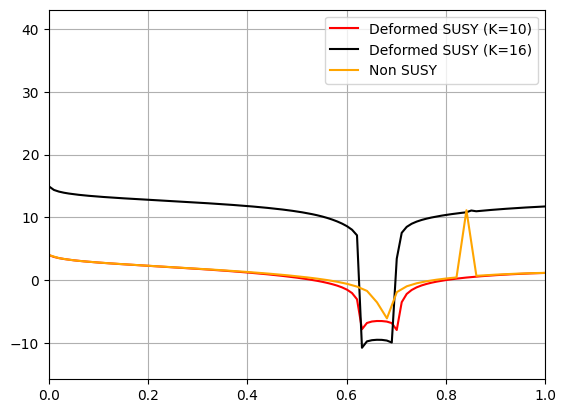

In [52]:
data = np.load(f'./data/susy_x4_deform_one_particle_K_10.npz',allow_pickle=True)
plt.plot(data['Es'], np.log(np.fabs(data['ts'])),c='red',label='Deformed SUSY (K=10)')
data = np.load(f'./data/susy_x4_deform_one_particle_K_16.npz',allow_pickle=True)
plt.plot(data['Es'], np.log(np.fabs(data['ts'])),c='black',label='Deformed SUSY (K=16)')
data = np.load(f'./data/susy_test_non_susy_x4_K_10_shift_0.npz',allow_pickle=True)
plt.plot(data['Es'], data['ts'],c='orange',label='Non SUSY')
plt.xlim(0,1)
# plt.plot(Es, PPts)
plt.grid()
plt.legend()
plt.show()

In [50]:
np.savez('./data/susy_x4_deform_one_particle_K_10',Es=Es,ts=ts)